<a href="https://colab.research.google.com/github/JsonLin117/-/blob/main/Propet_AI_Tool_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import 不論跑什麼東西都先跑這一步

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter

from sklearn.datasets import load_iris, make_moons, load_diabetes

from sklearn import ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree, discriminant_analysis
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, LassoCV, LinearRegression, Ridge, ElasticNet, SGDRegressor, Lars, HuberRegressor, TheilSenRegressor, Lasso, OrthogonalMatchingPursuit, ARDRegression, BayesianRidge
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, BaggingClassifier,RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, LinearSVC, NuSVC, SVR, LinearSVR, NuSVR
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.neural_network import MLPClassifier


from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, ShuffleSplit, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler,  MaxAbsScaler, Binarizer, FunctionTransformer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.cluster import DBSCAN
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category = ConvergenceWarning)


sns.set(style='white', context='notebook', palette='deep')

# 數據轉換

In [29]:
def transform_feature(df, column_name, transformations):
     """
     對指定列套用不同的資料轉換。

     :param df: DataFrame，包含資料。
     :param column_name: 要轉換的列名。
     :param transformations: 包含要套用的轉換類型，如'log', 'sqrt', 'boxcox'。
     :return: DataFrame，包含原始和轉換後的列。
     """
     # 檢查列名是否在DataFrame中
     if column_name not in df.columns:
         raise ValueError(f"{column_name} does not exist in the DataFrame.")

     # 建立一個資料副本以避免修改原始數據
     df_transformed = df.copy()

     # 對每個指定的轉換類型進行處理
     for transform in transformations:
         if transform == 'log':
             # 對數轉換，處理非正值
             df_transformed[f'log_{column_name}'] = np.log(df_transformed[column_name] + 1)

         elif transform == 'sqrt':
             # 平方根轉換，處理非正值
             df_transformed[f'sqrt_{column_name}'] = np.sqrt(df_transformed[column_name] + 1)

         elif transform == 'boxcox':
             # Box-Cox 轉換，確保所有資料為正
             adjusted_column = df_transformed[column_name] + 1 - df_transformed[column_name].min()
             df_transformed[f'boxcox_{column_name}'], _ = stats.boxcox(adjusted_column)

         else:
             raise ValueError(f"Transformation '{transform}' is not supported.")

     return df_transformed

# 範例使用
data = pd.DataFrame({
     'sales': np.random.gamma(2, 2, 100) - 1 # 建立一些可能包含零或負數的數據
})

In [30]:
# 呼叫函數，轉換 'sales' 列
transformed_data = transform_feature(data, 'sales', ['log', 'sqrt', 'boxcox'])
print(transformed_data.head())

      sales  log_sales  sqrt_sales  boxcox_sales
0  4.246202   1.657504    2.290459      2.539093
1  5.755906   1.910417    2.599213      3.004623
2  1.520029   0.924270    1.587460      1.459333
3  2.582861   1.276162    1.892845      1.930635
4  6.471030   2.011033    2.733319      3.204654


# 特徵選擇

## 卡方檢驗（Chi-squared test）

In [ ]:

# 假設 data 是特徵，target 是目標變量
X = data   # 類別型特徵數據
y = target  # 類別型目標變量

# 應用卡方檢驗
chi_selector = SelectKBest(chi2, k=10)  # 選擇得分最高的前10個特徵
X_kbest = chi_selector.fit_transform(X, y)

print("Selected features:", X.columns[chi_selector.get_support()])

## 方差閾值（Variance Threshold）

In [ ]:
# 設置方差閾值
thresholder = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_high_variance = thresholder.fit_transform(X)

print("Selected features:", X.columns[thresholder.get_support()])

## LASSO (Least Absolute Shrinkage and Selection Operator)

In [ ]:
# 使用 LassoCV 來找到最佳的 alpha（正則化強度）
lasso = LassoCV(cv=5).fit(X, y)
model = SelectFromModel(lasso, prefit=True)
X_lasso = model.transform(X)

print("Selected features:", X.columns[model.get_support()])

# 缺失值處理

In [ ]:
# 普通處理方法
def handle_missing_values(data, columns, method='delete', fill_value=None):
    """
    處理數據裡的缺失值。

    Parameters:
    data (DataFrame): 需要處理的DataFrame。
    columns (list): 需要處理缺失值的列名。
    method (str): 缺失值處理方式。可選 'fill_mean'、'fill_median'、'fill_constant'、'delete'。
    fill_value (any): 當method為'fill_constant'時使用此值。
    """
    # 遍歷每一列處理缺失值
    for column in columns:
        if column in data.columns:
            if method == 'fill_mean':
                # 用平均數方法
                data[column].fillna(data[column].mean(), inplace=True)
            elif method == 'fill_median':
                # 用中位數方法
                data[column].fillna(data[column].median(), inplace=True)
            elif method == 'fill_constant':
                # 用constant
                if fill_value is not None:
                    data[column].fillna(fill_value, inplace=True)
                else:
                    raise ValueError("fill_value cannot be None when method is 'fill_constant'.")
            elif method == 'delete':
                # 删除含有缺失值的行
                data.dropna(subset=[column], inplace=True)
            else:
                raise ValueError("Method not supported. Choose 'fill_mean', 'fill_median', 'fill_constant', or 'delete'.")
        else:
            raise ValueError(f"Column {column} does not exist in DataFrame.")
    return data

In [ ]:
# 示範
data = pd.DataFrame({
    'A': [1, 2, np.nan, 4],
    'B': [np.nan, 2, 3, 4],
    'C': [1, 2, 3, np.nan]
})

# 用平均數
processed_data = handle_missing_values(data, ['A', 'B'], method='fill_mean')
print(processed_data)

# 用常數
processed_data = handle_missing_values(data, ['C'], method='fill_constant', fill_value=0)
print(processed_data)

In [ ]:
# 機器學習處理方法
def impute_missing_values_ml_classification(data, max_iter=10):
    """
    使用機器學習方法填入DataFrame中的缺失值。

    參數:
     data (DataFrame): 需要處理的Pandas DataFrame。
     strategy (str): 使用的模型策略，目前用 'random_forest'。
     max_iter (int): 最大迭代次數，用於迭代模型。

    回傳:
     DataFrame: 填入缺失值的DataFrame
    """
    # 使用隨機森林 還有LinearRegression, KNeighborsRegressor等
    estimator = RandomForestClassifier(n_estimators=10, random_state=0)


    imputer = IterativeImputer(estimator=estimator, max_iter=max_iter, random_state=0)
    # 轉換數據，填充缺失值
    imputed_data = imputer.fit_transform(data)
    # 將填入後的資料轉換回DataFrame
    imputed_data_df = pd.DataFrame(imputed_data, columns=data.columns)
    return imputed_data_df

In [ ]:
# 示範
data = pd.DataFrame({
    'A': [1, 2, np.nan, 4],
    'B': [np.nan, 2, 3, 4],
    'C': [1, 2, 3, np.nan]  # 假設這是一個分類特徵
})

processed_data = impute_missing_values_ml_classification(data)
print(processed_data)

# 異常值處理

In [ ]:
# DBSCAN
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import pandas as pd

# Load data
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# 數據標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# DBSCAN
db = DBSCAN(eps=0.5, min_samples=5)
labels = db.fit_predict(X_scaled)

# 新增標籤到資料中以識別雜訊點
X['cluster_label'] = labels
X['is_noise'] = X['cluster_label'] == -1

# 查看噪音點
print(X[X['is_noise']])

# 刪除雜訊點
X_clean = X[X['cluster_label'] != -1]

# 或替換雜訊點的值
# 這裡以平均值替換，你可以根據需要選擇其他方法
for column in X.columns[:-2]:  # 排除最後新增的標籤列
    mean_value = X[X['cluster_label'] != -1][column].mean()
    X.loc[X['is_noise'], column] = mean_value

# 再次查看處理後的數據
print(X.head())


Outliers in sepal length (cm) based on Z-Score:
15    5.7
Name: sepal length (cm), dtype: float64
Outliers in sepal width (cm) based on Z-Score:
1    3.0
Name: sepal width (cm), dtype: float64

Data after removing outliers:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         149.000000        149.000000         149.000000   
mean            5.844295          3.048322           3.773154   
std             0.830775          0.423085           1.761435   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.400000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.200000           6.900000   

       petal width (cm)  
count        149.000000  
mean           1.204698  
std            0.761962  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%     

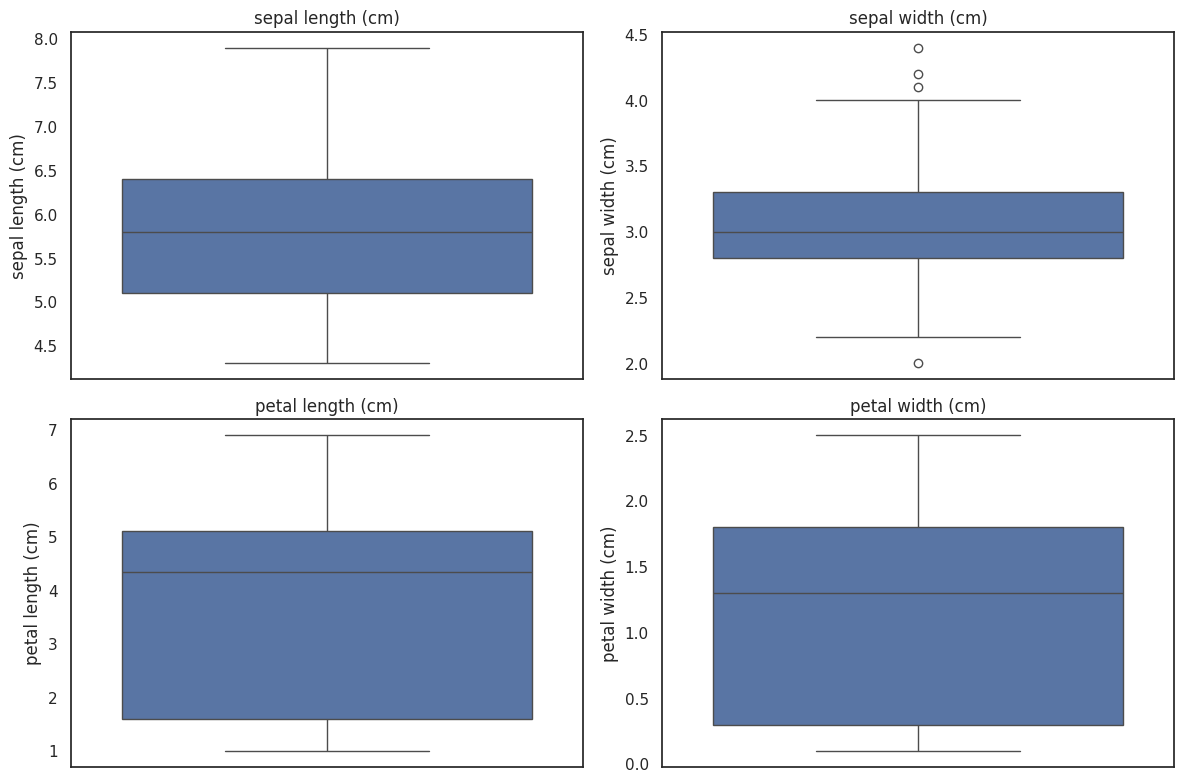

In [ ]:
# Load Data
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# 計算 Z-Score
z_scores = np.abs(stats.zscore(X))
threshold = 3

# 找到異常值的位置
outliers = np.where(z_scores > threshold)

# 標記或刪除異常值
# 我們將列印出異常值
for feature, outlier_indices in zip(X.columns, outliers):
    if outlier_indices.size > 0:
        print(f"Outliers in {feature} based on Z-Score:")
        print(X.iloc[outlier_indices][feature])

# 可選擇刪除異常值
X_clean = X[(z_scores < threshold).all(axis=1)]
print("\nData after removing outliers:")
print(X_clean.describe())

# 可視化資料分佈，檢查處理後的效果
import seaborn as sns
import matplotlib.pyplot as plt

# 對每個特徵畫箱形圖
plt.figure(figsize=(12, 8))
for i, feature in enumerate(X.columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=X[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

In [ ]:
# 四分位数（IQR, Interquartile Range）的方法 / Tukey's Method
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers

# 數據預處理

In [ ]:
# 建立一個範例DataFrame
np.random.seed(42)
data = pd.DataFrame({
    'A': np.random.normal(0, 1, 100),
    'B': np.random.normal(10, 5, 100),
    'C': np.random.exponential(1, 100),
    'D': np.random.randint(100, size=100)
})
print(data.head())
# 故意加入一些缺失值
data.iloc[0:10, 1] = np.nan
data.iloc[5:15, 2] = np.nan

# 使用log1p對正偏資料進行轉換使用log1p对正偏数据进行转换
log_transformer = FunctionTransformer(np.log1p, validate=True)

# 預處理步驟
preprocessing_steps = ColumnTransformer([
    ('impute_scale', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # 處理缺失值
        ('scaler', StandardScaler())                 # 標準化
    ]), ['A', 'B']),
    ('minmax_log', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), # 先填充缺失值
        ('log', log_transformer),
        ('minmax_scaler', MinMaxScaler())            # 最小-最大標準化
    ]), ['C']),
    ('maxabs_bin', Pipeline([
        ('maxabs_scaler', MaxAbsScaler()),           # 絕對值最大標準化
        ('binarizer', Binarizer(threshold=0.5))      # 二值化
    ]), ['D'])
])

# 應用預處理
data_transformed = preprocessing_steps.fit_transform(data)

# 轉換後的資料轉為 DataFrame 以方便查看
data_transformed_df = pd.DataFrame(data_transformed, columns=['A_scaled', 'B_scaled', 'C_log_minmax', 'D_maxabs_bin'])

print(data_transformed_df.head())

          A         B         C   D
0  0.496714  2.923146  2.098609  11
1 -0.138264  7.896773  1.350034  66
2  0.647689  8.286427  1.194074  64
3  1.523030  5.988614  1.212288  32
4 -0.234153  9.193571  0.445492  39
   A_scaled      B_scaled  C_log_minmax  D_maxabs_bin
0  0.664619 -3.894555e-16      0.725902           0.0
1 -0.038089 -3.894555e-16      0.546127           1.0
2  0.831697 -3.894555e-16      0.501484           1.0
3  1.800406 -3.894555e-16      0.506858           0.0
4 -0.144206 -3.894555e-16      0.230180           0.0


# 類別欄位轉換

In [5]:
def convert_to_dummies(df, columns, prefix_dict=None):
     """
     將指定列轉換為虛擬（指示器）變數。

     :param df: DataFrame，包含資料。
     :param columns: list，包含需要轉換為虛擬變數的列名。
     :param prefix_dict: dict，可選，列名與對應前綴的字典。
     :return: DataFrame，包含轉換後的虛擬變數。
     """
     for column in columns:
         if prefix_dict and column in prefix_dict:
             df = pd.get_dummies(df, columns=[column], prefix=prefix_dict[column])
         else:
             df = pd.get_dummies(df, columns=[column])
     return df

# 範例使用
dataset = pd.DataFrame({
     'Title': ['Mr', 'Mrs', 'Miss', 'Mr', 'Mrs'],
     'Embarked': ['S', 'C', 'C', 'S', 'S'],
     'color': ['red', 'blue', 'green', 'blue', 'blue']
})

In [6]:
dataset_transformed = convert_to_dummies(dataset, ['Title', 'Embarked', 'color'], prefix_dict={'Embarked': 'Em'})
print(dataset_transformed)

   Title_Miss  Title_Mr  Title_Mrs   Em_C   Em_S  color_blue  color_green  \
0       False      True      False  False   True       False        False   
1       False     False       True   True  False        True        False   
2        True     False      False   True  False       False         True   
3       False      True      False  False   True        True        False   
4       False     False       True  False   True        True        False   

   color_red  
0       True  
1      False  
2      False  
3      False  
4      False  


# 合併兩個csv 相同列名的數據

In [ ]:
# Google Drive read CSV files，假設文件名稱為 'file1.csv' 和 'file2.csv'
# file1_path = '/content/drive/MyDrive/file1.csv'
# file2_path = '/content/drive/MyDrive/file2.csv'

# 或是上傳到Files 讀取文件名稱
file1_path = 'file1.csv' # 改成上傳的檔案名稱
file2_path = 'file2.csv' # 改成上傳的檔案名稱

# read CSV 文件
df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# 如果是Excel
# df1 = pd.read_excel(file1_path)
# df2 = pd.read_excel(file2_path)

# merge df1 & df2
merged_df = pd.merge(df1, df2, on='common_column')

print(merged_df)

# save csv to google drive or save to Files
# merged_df.to_csv('/content/drive/MyDrive/merged_file.csv', index=False)
merged_df.to_csv('merged_file.csv', index=False)

# 如果是Excel
# merged_df.to_excel('/content/drive/MyDrive/merged_file.xlsx', index=False)
# merged_df.to_excel('merged_file.xlsx', index=False)

# 轉換日期格式

In [ ]:
# 假設csv檔案名稱為 'data.csv'
# file_path = '/content/drive/MyDrive/data.csv'
file_path = 'data.csv'

# 如果是Excel
# file_path = '/content/drive/MyDrive/data.xlsx'
# file_path = 'data.xlsx'

df = pd.read_csv(file_path)
# df = pd.read_excel(file_path)

# 假設 'date_column' 是包含日期的列
# 日期格式 'YYYY-MM-DD', 'YYYY/MM/dd', 'YYYYMMDD'
df['date_column'] = pd.to_datetime(df['date_column'], format='%Y-%m-%d')

print(df)
# df.to_csv('/content/drive/MyDrive/converted_data.csv', index=False)
df.to_csv('converted_data.csv', index=False)

#如果是Excel
# df.to_excel('/content/drive/MyDrive/converted_data.xlsx', index=False)
# df.to_excel('converted_data.xlsx', index=False)

# GridSearchCV 找最佳parameters

## 分類

In [ ]:
X, y = load_iris(return_X_y=True)

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
default_models = {
    'LinearSVM': SVC(kernel='linear', probability=True),
    'LogisticRegression': LogisticRegression(max_iter=200)
}
default_scores = {}
for name, model in default_models.items():
    scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    default_scores[name] = np.mean(scores)
    print(f"{name} with default parameters score: {default_scores[name]:.4f}")

LinearSVM with default parameters score: 0.9867
LogisticRegression with default parameters score: 0.9667


In [ ]:
models_params = {
    'ExtraTrees': {
        'model': ExtraTreesClassifier(random_state=42),
        'params': {
            'max_features': [0.5, 0.7, 1.0],
            'n_estimators': [50, 100, 300],
            'max_depth': [None, 10, 50, 100],
            'max_leaf_nodes': [None, 50, 100, 200],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        }
    },
    'NuSVC': {
        'model': NuSVC(probability=True),
        'params': {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['auto', 0.001, 0.01, 0.1, 1],
            'nu': [0.1, 0.5, 0.9],
            'max_iter': [-1, 1000, 10000]
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['auto', 0.001, 0.01, 0.1, 1],
            'max_iter': [-1, 1000, 10000]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [50, 100, 300],
            'learning_rate': [0.01, 0.1, 0.5]
        }
    },
    'KNeighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 10],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski'],
            'p': [1, 2],  # 1: Manhattan distance, 2: Euclidean distance
            'leaf_size': [10, 30, 50]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'gamma': [0, 0.1, 0.5],
            'n_estimators': [50, 100, 300],
            'learning_rate': [0.01, 0.1, 0.5],
            'max_depth': [3, 5, 10],
            'subsample': [0.5, 0.9, 1.0]
        }
    },
    'Ridge': {
        'model': RidgeClassifier(),
        'params': {
            'alpha': [0.1, 1, 10],
            'max_iter': [1000, 10000]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'max_features': [0.5, 0.7, 1.0],
            'n_estimators': [50, 100, 300],
            'max_depth': [None, 10, 50, 100],
            'max_leaf_nodes': [None, 50, 100, 200],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        }
    },
    'Bagging': {
        'model': BaggingClassifier(random_state=42),
        'params': {
            'n_estimators': [10, 50, 100],
            'max_samples': [0.5, 0.7, 1.0],  # 比例
            'max_features': [0.5, 0.7, 1.0],  # 比例
            'bootstrap': [True, False],
            'bootstrap_features': [True, False]
        }
    },
    'SGD': {
        'model': SGDClassifier(random_state=42),
        'params': {
            'alpha': [0.0001, 0.001, 0.01],
            'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
            'penalty': ['l1', 'l2', 'elasticnet']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 10, 50, 100],
            'max_leaf_nodes': [None, 50, 100, 200],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        }
    }
}

best_models = {}
for name, mp in models_params.items():
    print(f"Running GridSearchCV for {name}.")
    grid_search = GridSearchCV(estimator=mp['model'], param_grid=mp['params'], cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X, y)
    best_models[name] = (grid_search.best_estimator_, grid_search.best_score_, grid_search.best_params_)
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best score for {name}: {grid_search.best_score_:.4f}")
    print('-'*30)


for model_name, (model, score, params) in best_models.items():
    print(f"{model_name} best score: {score:.4f}")
    print(f"{model_name} best parameters: {params}")


In [ ]:
print("Comparison of default parameters models and optimized models:")
for name, score in default_scores.items():
    print(f"{name} default score: {score:.4f}")

for model_name, (model, score, params) in best_models.items():
    print(f"{model_name} optimized score: {score:.4f} with params: {params}")

## 回歸

In [2]:
# Load Data
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
default_models = {
    "Orthogonal Matching Pursuit": OrthogonalMatchingPursuit(),
    "Automatic Relevance Determination": ARDRegression(),
    "Bayesian Ridge": BayesianRidge()
}
for name, model in default_models.items():
    model.fit(X_train, y_train)  # 訓練模型
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')  # 交叉驗證
    print(f"{name} Mean Cross-Validation MSE: {np.mean(scores):.2f}")

    # 對測試集進行預測並計算 MSE
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} Test MSE: {mse:.2f}")
    print("-" * 30)

Orthogonal Matching Pursuit Mean Cross-Validation MSE: -3928.30
Orthogonal Matching Pursuit Test MSE: 4061.83
------------------------------
Automatic Relevance Determination Mean Cross-Validation MSE: -3115.32
Automatic Relevance Determination Test MSE: 2823.74
------------------------------
Bayesian Ridge Mean Cross-Validation MSE: -3128.39
Bayesian Ridge Test MSE: 2871.76
------------------------------


In [6]:
# Models & parameters
models_params = {
    'AdaBoostRegressor': {
        'model': AdaBoostRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 300],
            'learning_rate': [0.01, 0.1, 0.5]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(random_state=42),
        'params': {
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.1, 0.5, 0.9]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.5],
            'max_depth': [3, 5, 10]
        }
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'BaggingRegressor': {
        'model': BaggingRegressor(random_state=42),
        'params': {
            'n_estimators': [10, 50, 100],
            'max_samples': [0.5, 1.0],
            'max_features': [0.5, 1.0],
            'bootstrap': [True, False],
            'bootstrap_features': [True, False]
        }
    },
    'ExtraTreesRegressor': {
        'model': ExtraTreesRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'NuSVR': {
        'model': NuSVR(),
        'params': {
            'nu': [0.1, 0.5, 0.9],
            'C': [0.1, 1, 10],
            'gamma': ['auto', 0.01, 0.1]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'poly', 'rbf'],
            'gamma': ['auto', 0.01, 0.1]
        }
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [None, 10, 50],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 10],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'XGBoostRegressor': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [50, 100, 300],
            'learning_rate': [0.01, 0.1, 0.5],
            'max_depth': [3, 5, 10]
        }
    },
    'HuberRegressor': {
        'model': HuberRegressor(),
        'params': {
            'epsilon': [1.35, 1.5, 1.75],
            'alpha': [0.0001, 0.001, 0.01]
        }
    },
    'Lars': {
        'model': Lars(),
        'params': {
            'n_nonzero_coefs': [1, np.inf]  # Lars specific parameter
        }
    },
    'TheilSenRegressor': {
        'model': TheilSenRegressor(random_state=42),
        'params': {
            'max_subpopulation': [10000, 20000]
        }
    },
    'SGDRegressor': {
        'model': SGDRegressor(random_state=42),
        'params': {
            'alpha': [0.0001, 0.001, 0.01],
            'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
            'penalty': ['l1', 'l2', 'elasticnet']
        }
    },
    'LinearSVR': {
        'model': LinearSVR(),
        'params': {
            'C': [0.1, 1, 10],
            'max_iter': [1000, 10000],
            'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.0001, 0.001, 0.01],
            'max_iter': [1000, 10000],
        }
    },
}

# GridSearchCV
best_models = {}
for name, mp in models_params.items():
    print(f"Running GridSearchCV for {name}.")
    grid_search = GridSearchCV(estimator=mp['model'], param_grid=mp['params'], cv=kfold, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = (grid_search.best_estimator_, -grid_search.best_score_, grid_search.best_params_)
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best MSE for {name}: {-grid_search.best_score_:.4f}")
    print('-'*30)

# 測試集上評估
for model_name, (model, mse, params) in best_models.items():
    y_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred)
    print(f"{model_name} Test MSE: {mse_test:.4f}")

Running GridSearchCV for AdaBoostRegressor.
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for AdaBoostRegressor: {'learning_rate': 0.01, 'n_estimators': 300}
Best MSE for AdaBoostRegressor: 3350.4610
------------------------------
Running GridSearchCV for Ridge.
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for Ridge: {'alpha': 0.1}
Best MSE for Ridge: 3074.8292
------------------------------
Running GridSearchCV for ElasticNet.
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.9}
Best MSE for ElasticNet: 4410.2444
------------------------------
Running GridSearchCV for GradientBoostingRegressor.
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for GradientBoostingRegressor: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best MSE for GradientBoostingRegressor: 3440.4339
------------------------------
Running GridSearchCV for RandomForestRegressor.
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for RandomForestRegressor: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best MSE for RandomForestRegressor: 3280.8758
------------------------------
Running GridSearchCV for BaggingRegressor.
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for BaggingRegressor: {'bootstrap': True, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}
Best MSE for BaggingRegressor: 3254.7143
------------------------------
Running GridSearchCV for ExtraTreesRegressor.
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for ExtraTreesRegressor: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best MSE for ExtraTreesRegressor: 3241.6765
------------------------------
Running GridSearchCV for NuSVR.
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for NuSVR: {'C': 10, 'gamma': 'auto', 'nu': 0.5}
Best MSE for NuSVR: 5963.0660
------------------------------
Running GridSearchCV for SVR.
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for SVR: {'C': 10, 'gamma': 'auto', 'kernel': 'linear'}
Best MSE for SVR: 5390.8338
------------------------------
Running GridSearchCV for DecisionTreeRegressor.
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for DecisionTreeRegressor: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best MSE for DecisionTreeRegressor: 4451.3790
------------------------------
Running GridSearchCV for KNeighborsRegressor.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for KNeighborsRegressor: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
Best MSE for KNeighborsRegressor: 3605.4130
------------------------------
Running GridSearchCV for XGBoostRegressor.
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for XGBoostRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best MSE for XGBoostRegressor: 3457.2242
------------------------------
Running GridSearchCV for HuberRegressor.
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for HuberRegressor: {'alpha': 0.001, 'epsilon': 1.75}
Best MSE for HuberRegressor: 3073.5505
------------------------------
Running GridSearchCV for Lars.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for Lars: {'n_nonzero_coefs': 1}
Best MSE for Lars: 5607.6565
------------------------------
Running GridSearchCV for TheilSenRegressor.
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py", line 1123, in fit
    self._validate_par

Best parameters for TheilSenRegressor: {'max_subpopulation': 20000}
Best MSE for TheilSenRegressor: 3117.2900
------------------------------
Running GridSearchCV for SGDRegressor.
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 1582, in fit
    self._v

Best parameters for SGDRegressor: {'alpha': 0.0001, 'loss': 'squared_epsilon_insensitive', 'penalty': 'l1'}
Best MSE for SGDRegressor: 3293.4166
------------------------------
Running GridSearchCV for LinearSVR.
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for LinearSVR: {'C': 10, 'loss': 'squared_epsilon_insensitive', 'max_iter': 10000}
Best MSE for LinearSVR: 3064.3534
------------------------------
Running GridSearchCV for Lasso.
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for Lasso: {'alpha': 0.001, 'max_iter': 1000}
Best MSE for Lasso: 3069.0442
------------------------------
AdaBoostRegressor Test MSE: 2721.4364
Ridge Test MSE: 2856.4869
ElasticNet Test MSE: 3792.1292
GradientBoostingRegressor Test MSE: 2779.9946
RandomForestRegressor Test MSE: 2902.3291
BaggingRegressor Test MSE: 2996.9026
ExtraTreesRegressor Test MSE: 2628.4431
NuSVR Test MSE: 5096.6584
SVR Test MSE: 4419.7927
DecisionTreeRegressor Test MSE: 3545.0

# Visualize Data & Data Exploration

## 統計概述

In [7]:
X, y = load_iris(return_X_y=True)

In [18]:
# Array 的情況
mean = np.mean(X, axis=0)
median = np.median(X, axis=0)
std_dev = np.std(X, axis=0)
variance = np.var(X, axis=0)
print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Standard Deviation: {std_dev}")
print(f"Variance: {variance}")

Mean: [5.84333333 3.05733333 3.758      1.19933333]
Median: [5.8  3.   4.35 1.3 ]
Standard Deviation: [0.82530129 0.43441097 1.75940407 0.75969263]
Variance: [0.68112222 0.18871289 3.09550267 0.57713289]


In [19]:
# DataFrame 的情況
df = pd.DataFrame(X)
df.describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## 熱力圖

In [20]:
# 假設 train 是已載入的 DataFrame
# train = pd.read_csv('your_data.csv') # 模擬載入數據

def plot_correlation_heatmap(df, y_col, x_cols, cmap='coolwarm', fmt=".2f"):
     """
     繪製特定列的相關性熱力圖。

     :param df: DataFrame，包含資料。
     :param y_col: 目標變數的列名。
     :param x_cols: list of strings，特徵變數的列名清單。
     :param cmap: 熱力圖映射。('coolwarm', 'BrBG')
     :param fmt: 顯示在熱力圖單元格中的浮點數格式。
     """
     # 檢查列名是否存在於DataFrame中
     missing_cols = [col for col in [y_col] + x_cols if col not in df.columns]
     if missing_cols:
         raise ValueError(f"Columns {missing_cols} not in DataFrame.")

     # 建立相關性矩陣
     correlation_matrix = df[[y_col] + x_cols].corr()

     # 繪製熱力圖
     plt.figure(figsize=(10, 8))
     sns.heatmap(correlation_matrix, annot=True, fmt=fmt, cmap=cmap)
     plt.title('Correlation Heatmap')
     plt.show()

# 範例使用
train = pd.DataFrame({
     'y': [1, 2, 3, 4, 5],
     'X1': [5, 4, 3, 2, 1],
     'X2': [1, 2, 1, 2, 1],
     'X3': [5, 3, 4, 2, 1],
     'X4': [7, 8, 7, 8, 7]
})

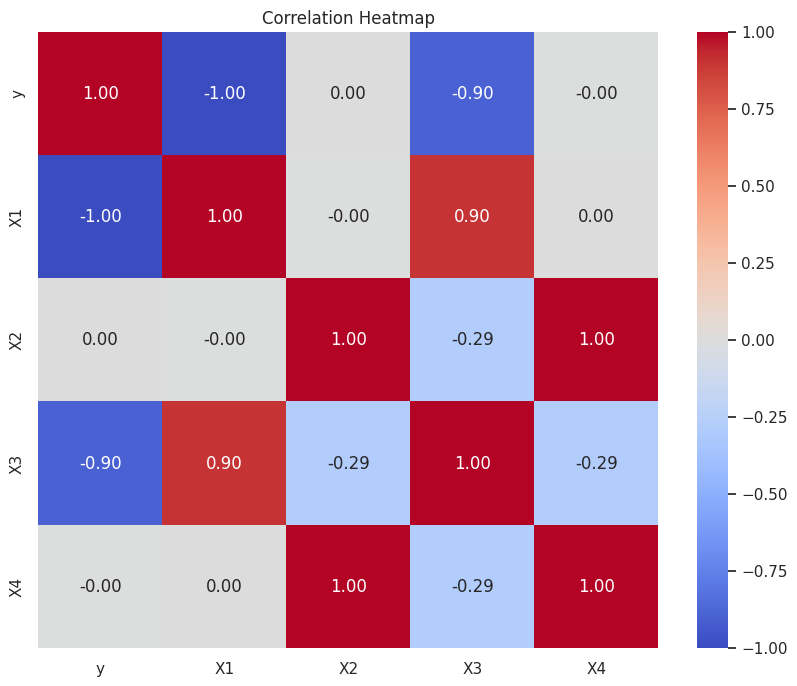

In [21]:
# 呼叫函數，指定目標變數和特徵變數
plot_correlation_heatmap(train, 'y', ['X1', 'X2', 'X3', 'X4']) # 自行更換

## 比較X特徵與y的關係 長方圖

In [32]:
def plot_categorical_relationship(df, x_col, y_col, kind="bar", palette="muted", title="", xlabel="", ylabel="", hue=None, legend=True):
     """
     繪製分類關係圖，並根據hue參數分層顯示資料。

     :param df: DataFrame，包含資料。
     :param x_col: X軸上的特徵列名。
     :param y_col: Y軸上的特徵列名。
     :param kind: 圖的種類（'bar', 'box', 'violin', 'count', 'point'）。
     :param palette: 使用的調色盤。
     :param title: 圖的標題。
     :param xlabel: X軸的標籤。
     :param ylabel: Y軸的標籤。
     :param hue: 用於在圖中分層的分類變數列名。
     :param legend: 是否顯示圖例。
     """
     # 建立圖形
     g = sns.catplot(x=x_col, y=y_col, hue=hue, data=df, kind=kind, palette=palette, legend=legend)
     g.despine(left=True) # 移除左側邊框線
     g.set_axis_labels(xlabel, ylabel) # 設定軸標籤
     g.fig.suptitle(title) # 設定標題
     g.fig.subplots_adjust(top=0.9) # 調整標題位置

     if not legend:
         g._legend.remove() # 若不顯示圖例，請把 legend = 'False'

     # 顯示圖形
     plt.show()

# 範例使用
data = pd.DataFrame({
     'y': [1, 2, 3, 4, 5],
     'X1': ['A', 'B', 'A', 'B', 'A'],
     'Group': ['One', 'One', 'Two', 'Two', 'One']
})

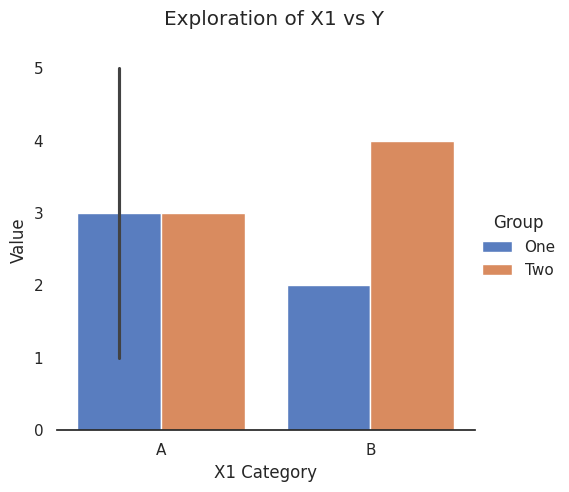

In [35]:
# 呼叫函數
plot_categorical_relationship(data, 'X1', 'y', kind="bar", palette="muted", title="Exploration of X1 vs Y", xlabel="X1 Category", ylabel="Value", hue='Group', legend=True)

In [ ]:
# 如果是分類 可以看每個分類下與X的關係
# Explore X1 vs y(可能有多個分類 ex:(Up, Down, Steady))
g = sns.FacetGrid(train, col="y")
g = g.map(sns.histplot, "X1", kde=True, stat = 'density', kde_kws=dict(cut=3))

## 查看特徵的分布圖

In [27]:
def plot_feature_distribution(df, feature_name, color="m", title="Feature Distribution"):
     """
     繪製特徵的分佈圖，包括直方圖和核密度估計。

     :param df: DataFrame，包含資料。
     :param feature_name: 要繪製的特徵列名。
     :param color: 圖表使用的顏色。
     :param title:圖表的標題。
     """
     # 檢查特徵是否存在於DataFrame中
     if feature_name not in df.columns:
         raise ValueError(f"{feature_name} does not exist in the DataFrame.")

     # 繪製核密度估計和直方圖
     plt.figure(figsize=(10, 6))
     sns.kdeplot(df[feature_name], color=color, label="Kernel Density Estimate", fill=True)
     sns.histplot(df[feature_name], color=color, kde=True, stat='density', alpha=0.3)
     plt.title(title)
     plt.xlabel(feature_name)
     plt.ylabel('Density')
     plt.legend(title="Skewness", labels=["%.2f" % df[feature_name].skew()])
     plt.grid(True)
     plt.show()

# 範例資料和使用
data = pd.DataFrame({
     'X': np.random.gamma(2, 2, 1000) # 產生一些範例數據
})

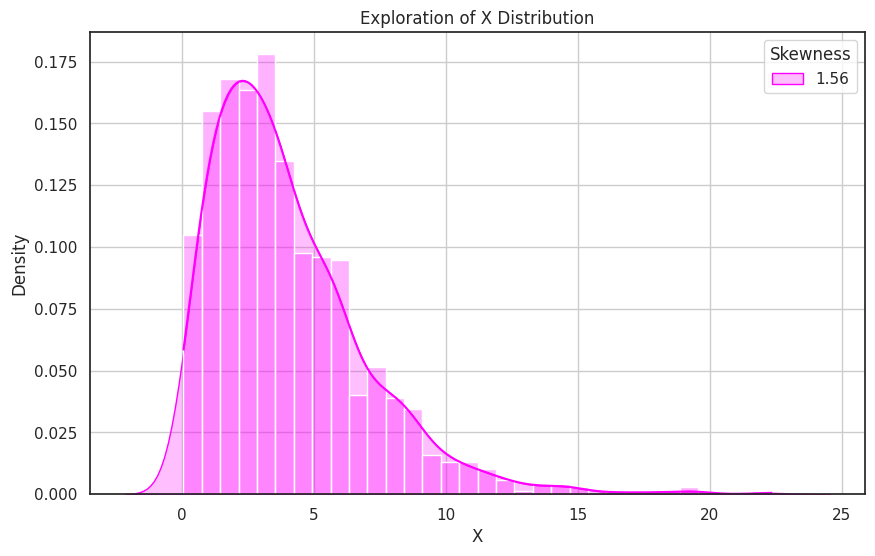

In [28]:
plot_feature_distribution(data, 'X', color="magenta", title="Exploration of X Distribution")

In [ ]:
# 如果分布偏態 需要轉換的話
# 調用 transform_feature(df, column_name, transformations) 上面"數據轉換"有寫

## 計數圖 (Count Plot)

In [48]:
def plot_count(df, x_col, order, palette, title, xlabel, ylabel, ticks, labels, hue=None):
     """
     繪製分類變數的計數圖。

     :param df: DataFrame，包含資料。
     :param x_col: 要計數的X軸上的特徵列名。
     :param order: X軸上顯示的順序。
     :param palette: 使用的調色盤。
     :param title: 圖的標題。
     :param xlabel: X軸的標籤。
     :param ylabel: Y軸的標籤。
     :param ticks: X軸刻度的位置。
     :param labels: X軸刻度的標籤。
     :param hue: 用於在圖中分層的分類變數列名。
     """
     # 建立計數圖
     if hue:
         g = sns.countplot(x=x_col, hue=hue, data=df, order=order, palette=palette)
     else:
         g = sns.countplot(x=x_col, data=df, order=order, palette=palette)

     plt.xlabel(xlabel)
     plt.ylabel(ylabel)
     plt.title(title)
     plt.xticks(ticks=ticks, labels=labels)
     if not hue:
         plt.legend([],[], frameon=False) # 若沒有使用hue參數，移除圖例
     plt.show()

# 範例數據
data = pd.DataFrame({
    'VehicleType': ['Car', 'Truck', 'Motorcycle', 'Bicycle', 'Car', 'Truck', 'Motorcycle', 'Bicycle'],
    'Color': ['Red', 'Blue', 'Red', 'Blue', 'Red', 'Blue', 'Red', 'Blue']
})

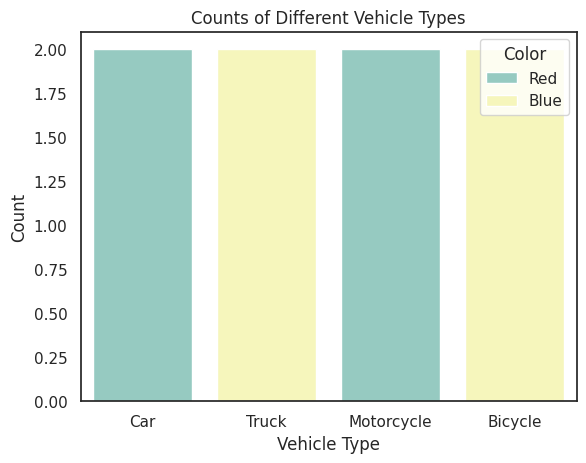

In [49]:
plot_count(
    df=data,
    x_col='VehicleType',
    order=['Car', 'Truck', 'Motorcycle', 'Bicycle'],
    palette='Set3',
    title='Counts of Different Vehicle Types',
    xlabel='Vehicle Type',
    ylabel='Count',
    ticks=[0, 1, 2, 3],
    labels=['Car', 'Truck', 'Motorcycle', 'Bicycle'],
    hue='Color'
)